In [ ]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def encode_integers(a, b):
    max_bits = max(a.bit_length(), b.bit_length()) + 1  # extra bit for sign
    a_binary = format(a & int("1" * max_bits, 2), f"0{max_bits}b")
    b_binary = format(b & int("1" * max_bits, 2), f"0{max_bits}b")

    #print("a_binary = ", a_binary)
    #print("b_binary = ", b_binary)

    return a_binary, b_binary

In [ ]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram

def create_oracle(a_binary, b_binary):
    n = len(a_binary)
    oracle = QuantumCircuit(n + 1)  # extra qubit for ancilla

    for i in range(n):
        if a_binary[i] != b_binary[i]:
            oracle.cx(i, n)

    return oracle

def create_oracle_1(a_binary, b_binary):
    n = len(a_binary)
    oracle = QuantumCircuit(n + 2)  # extra qubits for ancilla

    for i in range(n):
        if a_binary[i] == b_binary[i]:
            oracle.x(i)
            
    oracle.mct(list(range(n)), n)
    
    for i in range(n):
        if a_binary[i] == b_binary[i]:
            oracle.x(i)

    return oracle

In [ ]:
def create_diffuser(n, oracle):
    diffuser = QuantumCircuit(n + 1)
    diffuser.h(range(n))
    diffuser.append(oracle.inverse(), range(n + 1))
    diffuser.h(range(n))
    return diffuser

def create_diffuser_1(n):
    diffuser = QuantumCircuit(n + 1)

    diffuser.h(range(n))
    diffuser.append(create_oracle([0]*n, [1]*n), range(n + 1))
    diffuser.h(range(n))

    return diffuser

In [ ]:
def run_grover(a, b, num_iterations=1):
    a_binary, b_binary = encode_integers(a, b)
    n = len(a_binary)

    qc = QuantumCircuit(n + 2, n)
    qc.h(range(n))

    oracle = create_oracle_1(a_binary, b_binary)
    diffuser = create_diffuser_1(n)

    for _ in range(num_iterations):
        qc.append(oracle, range(n + 2))
        qc.append(diffuser, range(n + 1))

    qc.measure(range(n), range(n))

    backend = Aer.get_backend("qasm_simulator")
    counts = execute(qc, backend, shots=1000).result().get_counts()

    return counts

In [ ]:
from tqdm import tqdm

def run_grover_multiple_times(a, b, num_iterations, num_runs):
    aggregated_counts = {}
 
    for _ in tqdm(range(num_runs)):
        counts = run_grover(a, b, num_iterations)
        for key, value in counts.items():
            if key in aggregated_counts:
                aggregated_counts[key] += value
            else:
                aggregated_counts[key] = value
                
    return aggregated_counts

In [ ]:
import matplotlib.pyplot as plt

def plot_histogram_vertical_labels(data, **kwargs):
    # Extract labels and counts from the data
    labels = list(data.keys())
    counts = list(data.values())
    
    # Create the bar plot
    fig, ax = plt.subplots()
    bars = ax.bar(labels, counts, **kwargs)

    # Rotate the x-axis labels to be displayed vertically
    plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=8)

    # Display the counts above the bars, rotated vertically
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                str(count), ha='center', va='bottom', rotation='vertical', fontsize=8)

    # Show the plot
    plt.show()

    # Finds the most probable value after aggregrated runs
    highest_count_key = max(data, key=data.get)
    highest_count_value = data[highest_count_key]

    print("Highest count label:", highest_count_key)
    print("Highest count value:", highest_count_value)


100%|██████████| 10000/10000 [02:27<00:00, 67.92it/s]


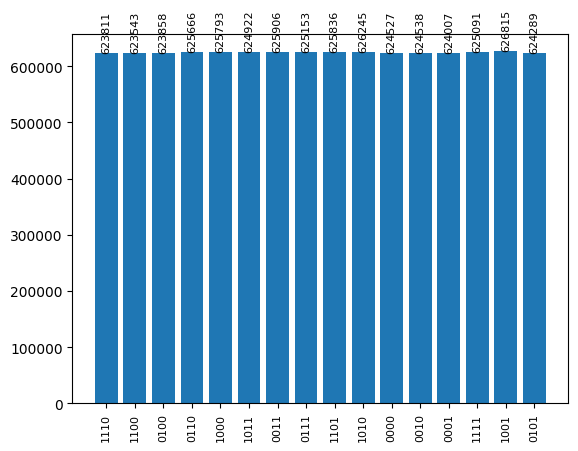

Highest count label: 1001
Highest count value: 626815


In [ ]:
a = -5
b = 3
num_iterations = 1  # Adjust this value to modify the number of iterations

num_runs = 10000
counts = run_grover_multiple_times(a, b, num_iterations, num_runs)

# Use the custom function with aggregated_counts
plot_histogram_vertical_labels(counts)

100%|██████████| 10000/10000 [03:24<00:00, 48.95it/s]


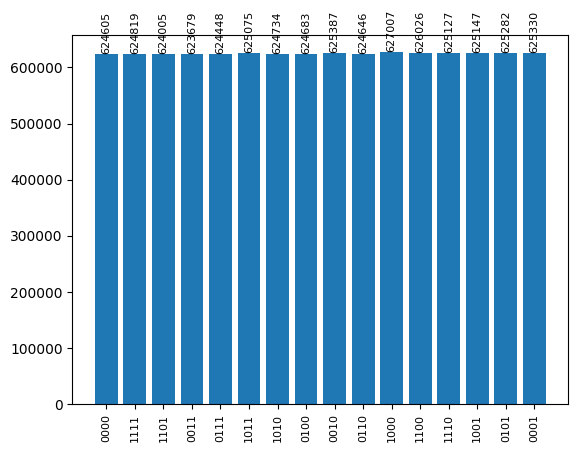

Highest count label: 1000
Highest count value: 627007


In [ ]:
a = -5
b = 3
num_iterations = 2  # Adjust this value to modify the number of iterations

num_runs = 10000
counts = run_grover_multiple_times(a, b, num_iterations, num_runs)

# Use the custom function with aggregated_counts
plot_histogram_vertical_labels(counts)

100%|██████████| 10000/10000 [04:13<00:00, 39.50it/s]


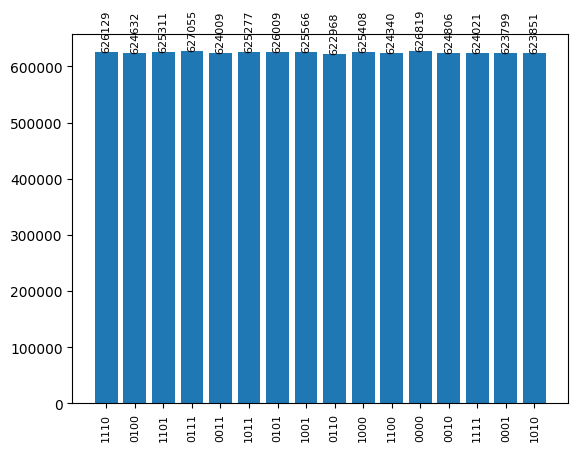

Highest count label: 0111
Highest count value: 627055


In [ ]:
a = -5
b = 3
num_iterations = 3  # Adjust this value to modify the number of iterations

num_runs = 10000
counts = run_grover_multiple_times(a, b, num_iterations, num_runs)

# Use the custom function with aggregated_counts
plot_histogram_vertical_labels(counts)